In [1]:
%matplotlib inline 
import xarray as xr
import os 
import pandas as pd
import numpy as np

In [2]:
import dask
import dask.array as dda
import dask.dataframe as ddf
import dask.distributed as dd
import dask_kubernetes as dk
import rhg_compute_tools.utils as rhgu
import rhg_compute_tools.kubernetes as rhgk

import intake

In [3]:
import xesmf as xe

In [4]:
# !pip install --upgrade --upgrade-strategy=only-if-needed intake-esm
# !pip install pydap

This notebook implements a scaling test for bias correction, using the BCSDTemperature model from `scikit-downscale`, with the daily BCSD bias correction method as implemented in the NASA-NEX dataset. 

Datasets used include a CMIP6 model from a historical run (`GISS-E2-1-G` from NASA) and GMFD (obs). Historical/training period is taken as 1980-1982, and the future/predict period is 1990-1991. 

GMFD is coarsened to the NASA `GISS-E2-1-G` grid for this bias correction test. 

Note that the purpose of this notebook is intended to allow us to get a better estimate of timing for global daily bias correction. Future work will build on this notebook to: 
- replace GMFD with ERA5
- combine this notebook with `SD_prototype.ipynb`, along with NASA-NEX data and a corresponding CMIP5 model, and over a limited domain, to test our implementation of BCSD against NASA-NEX for a limited domain. That notebook will be used as a prototype for our downscaling pipeline and can be modified to become a system test for the pipeline (1-3 gridcells for CI/CD, limited domain for science testing). 

In [5]:
client, cluster = rhgk.get_standard_cluster(extra_pip_packages="git+https://github.com/dgergel/xsd.git@feature/implement_daily_bcsd")
cluster

In [6]:
from skdownscale.pointwise_models import PointWiseDownscaler, BcsdTemperature

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
def _convert_lons(ds, lon_name='longitude'):
    '''
    converts longitudes from 0 to 360 to -180 to 180
    '''
    ds_conv_coords = ds.assign_coords(longitude=(((ds[lon_name] + 180) % 360) - 180))
    ds_sort = ds_conv_coords.sel(**{lon_name: np.sort(ds_conv_coords[lon_name].values)})
    return(ds_sort)

note that this workflow is modeled after Section 2.4 from `https://github.com/jhamman/scikit-downscale/blob/ecahm2020/examples/2020ECAHM-scikit-downscale.ipynb`, with key differences being: 
- obs dataset
- regridding methods
- downscaling method (using NASA-NEX method for quantile mapping versus the more traditional monthly one)

In [8]:
'''train_slice = slice('1980', '1982')  # train time range
holdout_slice = slice('1990', '1991')  # prediction time range'''

train_slice = slice('1980', '1989')  # train time range
holdout_slice = slice('1990', '2000')  # prediction time range

'''# bounding box of downscaling region
lon_slice = slice(-124.8, -120.0) 
lat_slice = slice(50, 45)'''

# chunk shape for dask execution (time must be contiguous, ie -1)
# chunks = {'lat': 10, 'lon': 10, 'time': -1}

'# bounding box of downscaling region\nlon_slice = slice(-124.8, -120.0) \nlat_slice = slice(50, 45)'

use GMFD since obs data above is just for the PNW

In [9]:
tmax_obs = xr.open_mfdataset(os.path.join('/gcs/rhg-data/climate/source_data/GMFD/tmax', 
                                         'tmax_0p25_daily_198*'), concat_dim='time', combine='nested',
                              parallel=True).squeeze(drop=True)

# standardize longitudes 
tmax_obs = _convert_lons(tmax_obs)

# remove leap days 
tmax_obs = tmax_obs['tmax'].sel(time=~((tmax_obs.time.dt.month == 2) & (tmax_obs.time.dt.day == 29)))

In [10]:
# gmfd_chunks = {'latitude': 10, 'longitude': 10, 'time': -1}
# obs_subset = tmax_obs.sel(time=train_slice).load(scheduler='threads').chunk(gmfd_chunks)
# obs_subset = tmax_obs.sel(time=train_slice).load()
obs_subset = tmax_obs.sel(time=train_slice)

In [11]:
# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
                 grid_label='gn')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
# access the data and do some cleanup
ds_model = cat['CMIP.NASA-GISS.GISS-E2-1-G.historical.day.gn'].to_dask(
           ).isel(member_id=0).squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds', 
                                                        'member_id'])

ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

In [59]:
ds_model

,Array,Chunk
Bytes,3.12 GB,49.97 MB
Shape,"(60225, 90, 144)","(964, 90, 144)"
Count,1175 Tasks,75 Chunks
Type,float32,numpy.ndarray


regrid obs to model resolution using `xESMF` 

In [13]:
def apply_weights(regridder, input_data):
    regridder._grid_in = None
    regridder._grid_out = None
    result = regridder(input_data)
    return result

In [14]:
chunks = {'latitude': len(obs_subset.latitude), 'longitude': len(obs_subset.longitude), 'time': 100}

obs_subset = obs_subset.chunk(chunks)

In [15]:
%%time
obs_to_mod_weights = '/home/jovyan/bias_correction_bilinear_weights_new.nc'
regridder_obs_to_mod = xe.Regridder(obs_subset.isel(time=0, drop=True)
                                    .rename({'latitude': 'lat', 'longitude': 'lon'}), 
                                    ds_model.isel(time=0, drop=True), 
                                    'bilinear', 
                                    filename=obs_to_mod_weights, reuse_weights=True)

Reuse existing file: /home/jovyan/bias_correction_bilinear_weights_new.nc
CPU times: user 30.4 ms, sys: 10.1 ms, total: 40.5 ms
Wall time: 35.3 ms


In [16]:
%%time
obs_subset_modres_lazy = xr.map_blocks(apply_weights, regridder_obs_to_mod, 
                                args=[tmax_obs.rename({'latitude': 'lat', 'longitude': 'lon'})])

CPU times: user 23.8 ms, sys: 2.2 ms, total: 26 ms
Wall time: 19.2 ms


In [17]:
%%time
obs_subset_modres = obs_subset_modres_lazy.compute()

CPU times: user 2.44 s, sys: 1.15 s, total: 3.59 s
Wall time: 32.5 s


In [18]:
obs_subset_modres.data.nbytes / (1024 ** 3)

0.35244226455688477

In [44]:
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [45]:
# regional subsets, ready for downscaling
train_subset = ds_model['tasmax'].sel(time=train_slice)
train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)


holdout_subset = ds_model['tasmax'].sel(time=holdout_slice)
holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


with loaded training and target data, use it to fit BcsdTemperature model at each x/y point in domain using the `PointwiseDownscaler`. Note that `PointwiseDownscaler._models` is a DataArray of BcsdTemperature models. 

In [46]:
%%time
model = PointWiseDownscaler(BcsdTemperature(return_anoms=False, time_grouper='daily_nasa-nex'))

CPU times: user 43 µs, sys: 0 ns, total: 43 µs
Wall time: 47.2 µs


In [47]:
model

<skdownscale.PointWiseDownscaler>
  Fit Status: False
  Model:
    BcsdTemperature(climate_trend_grouper=<function DAY_GROUPER at 0x7f67706fa158>,
                return_anoms=False,
                time_grouper=<class 'skdownscale.pointwise_models.groupers.PaddedDOYGrouper'>)

In [48]:
# remove leap days from model data
train_subset_noleap = train_subset.sel(time=~((train_subset.time.dt.month == 2) & 
                                                  (train_subset.time.dt.day == 29)))

In [49]:
holdout_subset_noleap = holdout_subset.sel(time=~((holdout_subset.time.dt.month == 2) & 
                                                  (holdout_subset.time.dt.day == 29)))

In [50]:
train_subset_noleap = train_subset_noleap.chunk(chunks)
holdout_subset_noleap = holdout_subset_noleap.chunk(chunks)
obs_subset_modres = obs_subset_modres.chunk(chunks)

In [51]:
%%time
# using Joe's example to isolate PointwiseDownscaler bug from 8/3 
model.fit(train_subset_noleap, obs_subset_modres)

CPU times: user 259 ms, sys: 8.35 ms, total: 267 ms
Wall time: 255 ms


In [52]:
display(model, model._models)

<skdownscale.PointWiseDownscaler>
  Fit Status: True
  Model:
    BcsdTemperature(climate_trend_grouper=<function DAY_GROUPER at 0x7f67706fa158>,
                return_anoms=False,
                time_grouper=<class 'skdownscale.pointwise_models.groupers.PaddedDOYGrouper'>)

<xarray.DataArray 'tasmax' (lat: 90, lon: 144)>
dask.array<_fit_wrapper-617f6c735f37578de912455ef91bfb5e-<this, shape=(90, 144), dtype=object, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0

In [53]:
%%time
predicted = model.predict(holdout_subset_noleap).load()

CPU times: user 3min 46s, sys: 21.5 s, total: 4min 7s
Wall time: 31min 20s


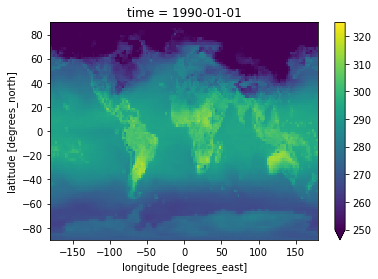

In [54]:
predicted.isel(time=0).plot(vmin=250, vmax=325)

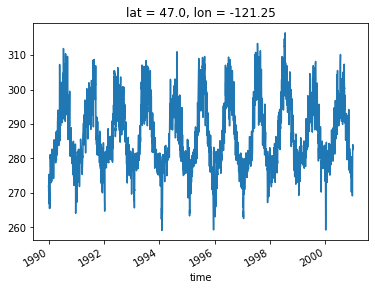

In [55]:
predicted.sel(lat=47, lon=-122, method='nearest').plot()

In [58]:
predicted.to_netcdf('/home/jovyan/global_bias_corrected_tenyears.nc')